In [1]:
using NBInclude
_PRECOMPILE_=false
_LC_ = true
@nbinclude("startup_GER.ipynb")

_tosave = false
suff = "ger"

# from the calibration
germany = update_Country2(
    α= 0.990610134263558,
  m= 0.11080110798470773,
  q0= 0.02,
  qa= 2.1386341611158708e-5,
  λ0= 0.08333333333333333,
  λ1= 0.05555555555555555)

C0 is Country2A(504.0, 456.0, 528.0, 780.0, 0.0048, NaN, NaN, NaN, NaN, NaN, NaN, 0.7, 0.68, 0.35, NaN, NaN, NaN)
Startup run in 24.83414888381958 secs.


Country2A(504.0, 456.0, 528.0, 780.0, 0.0048, 0.990610134263558, 0.02, 2.1386341611158708e-5, 0.11080110798470773, 0.05555555555555555, 0.08333333333333333, 0.7, 0.68, 0.35, 0.002986261647503093, 0.006000829684123419, 0.05415857109435786)

# 1) Simulation and plots
Plot the surplus.

Average cumulated nonemployment after 42 is 24.26906920130821in the model, and in the data 29.815890410958904


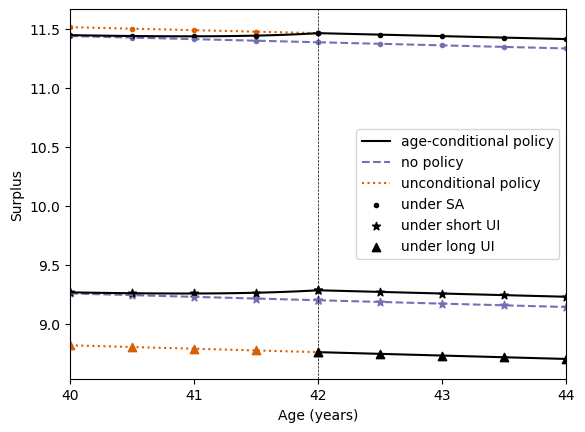

()

In [2]:
V = find_Surplus(germany)
println("Average cumulated nonemployment after 42 is ", average_U5(V, germany, Nind=100000), 
    "in the model, and in the data ",(892.9+28/2)/365*12)  
plot_surplus(V, germany, xlim=(40,44), xtic=40:44, markevery=6, loc=5)
_tosave ? savefig(joinpath(dir_graph,"surplus_$suff.png")) : ()

Plot the job-finding rates.

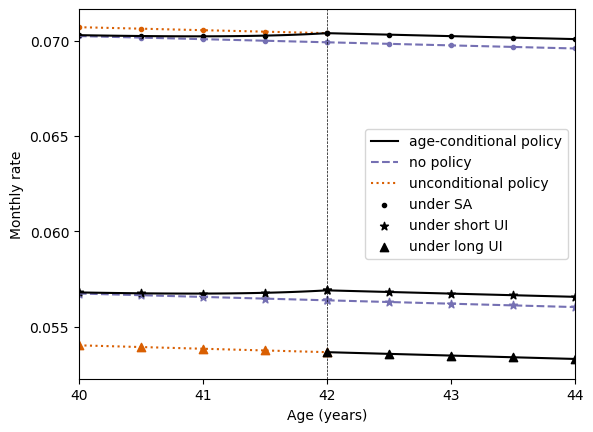

()

In [3]:
plot_JFR(V, germany, xlim=(40,44), xtic=40:44, markevery=6, ytic=0.055:0.005:0.07, loc=5)
_tosave ? savefig(joinpath(dir_graph,"jfr_$suff.png")) : ()

Plot the distribution of nonemployed workers.

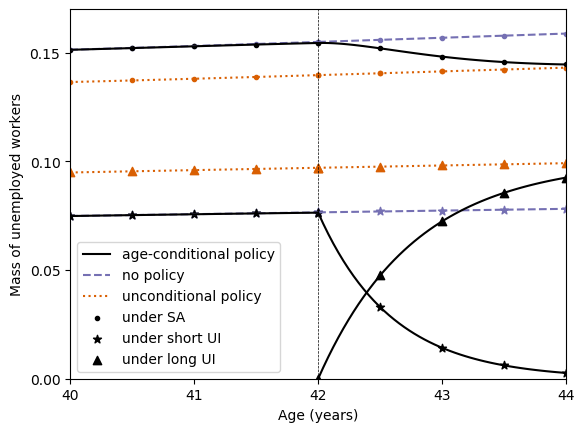

()

In [4]:
unemp = find_Unemp(V, germany) 
plot_unemp(unemp, germany, xlim=(40,44), xtic=40:44, markevery=6, ylim=(0,0.17), ytic=0:0.05:0.15, loc=3)
_tosave ? savefig(joinpath(dir_graph,"unemp_$suff.png")) : ()

Plot the dynamics of unemployment.

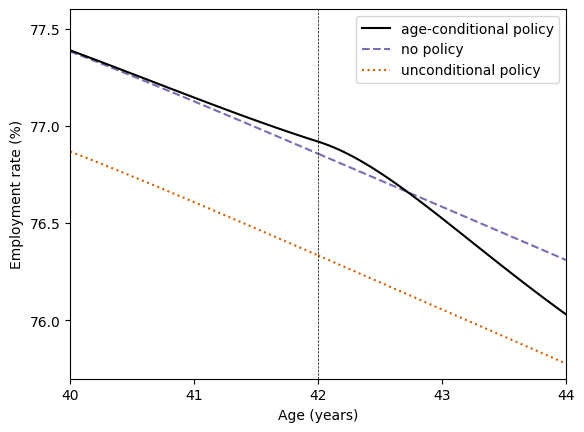

()

In [5]:
plot_emp(unemp, germany, xlim=(40,44), xtic=40:44, ytic=76:0.5:77.5, ylim=(75.7, 77.6)) 
_tosave ? savefig(joinpath(dir_graph,"emp_$suff.png")) : ()

Plot the average UI duration by age. 

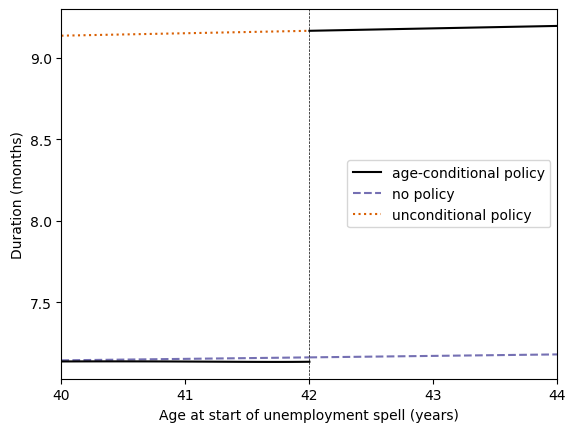

()

In [6]:
plot_expectedB(V, germany, xlim=(40,44), xtic=40:44, loc=5) 
_tosave ? savefig(joinpath(dir_graph,"UIdur_$suff.png")) : ()

Plot the average nonemployment duration by age.

The graphical LATE is 0.6968952115740077
The RDD estimand is 0.8158987823489383
The RDD bias corresponds to a share of the LATE: 0.1707625031690907


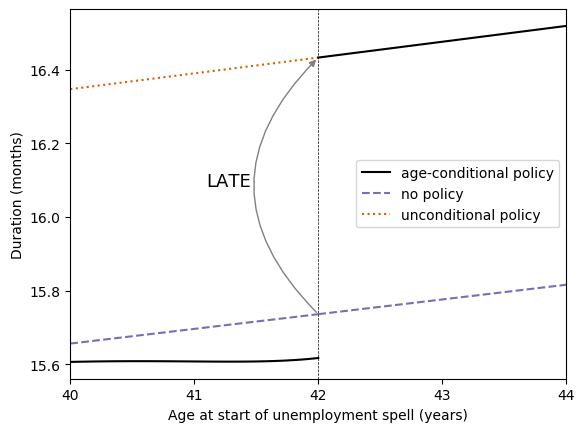

In [7]:
plot_expectedD(V, germany, xlim=(40,44), xtic=40:44, loc=5) 

## add annotation
expD_without = expectedD_without(germany.A, V, germany)
expD_with = expectedD_with(germany.A, V, germany)
annotate("",
    xy=(42, expD_without), xytext=(42, expD_with),
    arrowprops= Dict(:arrowstyle => "<|-", :color => :grey,
        :connectionstyle => "arc3,rad=0.5"))
annotate("LATE", xy=(41.1, (expD_without+expD_with)/2), fontsize=13)
_tosave ? savefig(joinpath(dir_graph,"NEdur_$suff.png")) : ()

LATE = expD_with-expD_without
println("The graphical LATE is $LATE")
expD_aft = expectedD(germany.A, V, germany)
expD_bef = expectedD(germany.A-0.001, V, germany)
RDDand = expD_aft-expD_bef
println("The RDD estimand is $RDDand")
println("The RDD bias corresponds to a share of the LATE: ", (RDDand-LATE)/LATE)

Plot the fit.

We print the targeted and simulated moments:


12×2 Matrix{Float64}:
 15.54  15.6077
 15.55  15.6073
 15.69  15.6073
 15.6   15.6078
 15.73  15.6094
 15.54  15.6124
 16.5   16.4401
 16.51  16.4473
 16.41  16.4544
 16.37  16.4616
 16.44  16.4687
 16.52  16.4759

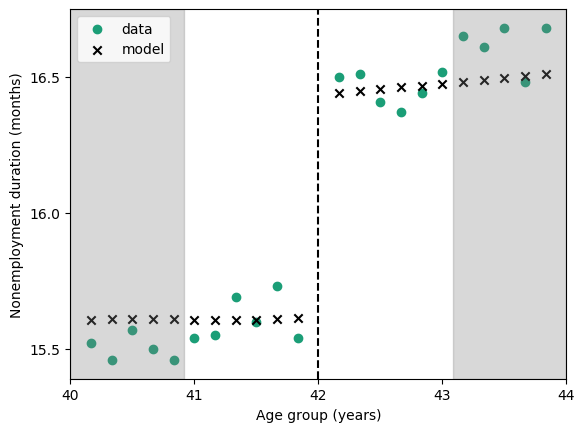

()

In [8]:
moments_model =  moments_germany(V,germany)
moments_model_all= moments_germany(V,germany, a_range=data_ger_NE.age)
  
println("We print the targeted and simulated moments:")
display(hcat(moments_target, moments_model))

plot_fit(data_ger_NE, moments_model_all, germany, 
    xlim=(40,44), xtic=40:44, xshades=(41-1/12, 43+1/12), ytic=15.5:0.5:16.5)
_tosave ? savefig(joinpath(dir_graph,"fit_ger.png")) : ()

# 2) RDD with simulated model
We generate the simulated data points. We define $Y_a$ as the average nonemployment duration at age $a$ in months. 

In [9]:
@time let 
freq = 1/12 # 1 for yearly, 1/12 for monthly, 1/365 for daily, do not change with daily freq
age_grid0 = ( 40:freq:44 ) *12
Y = [expectedD(m,V,germany) for m in age_grid0]
    
table = zeros(7)

#explaining variables
TREAT = age_grid0 .>= germany.A
consta = ones(size(age_grid0))
age1 = collect(age_grid0)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- germany.A) .* TREAT 
age2_spl = (age1 .- germany.A).^2 .* TREAT 
age3_spl = (age1 .- germany.A).^3 .* TREAT 

## no trend
X = hcat(TREAT, consta)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1] 

## linear spline
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1]

## cubic spline
X = hcat(TREAT, consta, age1, age1_spl, age2, age2_spl, age3, age3_spl)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]
    
## with different bandwidths
for (i,band) in enumerate([2.,1.,0.5,0.2] *12)

    myindexes = germany.A - band .<= age_grid0 .<= germany.A + band
    age_grid = age_grid0[myindexes]
    newY = Y[myindexes]
    
    #explaining variables
    TREAT = age_grid .>= germany.A
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- germany.A) .* TREAT 

    ## linear spline
    X = hcat(TREAT, consta, age1, age1_spl )   
    beta = inv(X' * X) * (X' * newY)
    table[3+i] = beta[1] 
end    
    
## RDD estimates from the data on the left
display(hcat([0,0,0,0.78, 0.92, 1.04, 0.79] ,table))
end

7×2 Matrix{Float64}:
 0.0   0.867553
 0.0   0.822856
 0.0   0.817176
 0.78  0.822856
 0.92  0.820747
 1.04  0.818113
 0.79  0.816505

  6.459410 seconds (52.51 M allocations: 4.186 GiB, 13.44% gc time, 57.96% compilation time)


Robustness for different $q_A$ in Appendix.

In [10]:
mytab = let
    par = [0.01 0.025 0.05 0.075 0.1; 0.011706723617807946 0.032658850823939156 0.0577175846463586 0.07737049387372501 0.08602828377850313; 0.04150950085065761 0.09030254793312315 0.16707000131701613 0.23998338951311257 0.305597067237708; 9.467733704175241e-6 4.727200293348477e-5 9.189604694867431e-5 0.00012840376260662783 0.00013408807244749392]
    ncol = size(par)[1]
    out = vcat(par, zeros(6,5)) 
    DataFrame(out, :auto)
end


## for each alternative set of parameters
@time for i in 1:ncol(mytab)
    newC = update_Country2(α=mytab[2,i], m=mytab[3,i], q0=mytab[1,i], qa=mytab[4,i], 
                        λ0=germany.λ0, λ1=germany.λ1) 
    newV = find_Surplus(newC)
    
    ## Nonemployment duration at A-12, A-0.01 and A 
    mytab[5:7,i] = [expectedD(a,newV,newC) for a in vcat(newC.A-12,newC.A-0.001,newC.A)]

    ## Estimates
    freq = 1/12 # 1 for yearly, 1/12 for monthly, 1/365 for daily
    age_grid = ( 40:freq:44 ) *12
    Y = [expectedD(a,newV,newC) for a in age_grid]
    TREAT = [a>=germany.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- germany.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl )
    beta = inv(X' * X) * (X' * Y)
    mytab[8,i] = 0.78
    mytab[9,i] = beta[1] 

    ## note estimand is mytab[7,i]-mytab[6,i]
    
    ## LATE
    expD_without = expectedD_without(newC.A, newV, newC)
    expD_with = expectedD_with(newC.A, newV, newC)
    mytab[10,i]  =  (expD_with-expD_without) 
end
mytab

115.008595 seconds (1.85 G allocations: 153.845 GiB, 18.64% gc time, 1.74% compilation time)


Row,x1,x2,x3,x4,x5
,Float64,Float64,Float64,Float64,Float64
1,0.01,0.025,0.05,0.075,0.1
2,0.0117067,0.0326589,0.0577176,0.0773705,0.0860283
3,0.0415095,0.0903025,0.16707,0.239983,0.305597
4,9.46773e-6,4.7272e-5,9.1896e-5,0.000128404,0.000134088
5,7.14934,5.87869,5.78425,5.81641,6.08034
6,7.30064,6.10055,5.91613,5.85134,5.9672
7,12.4164,9.26982,8.95745,8.97134,9.52154
8,0.78,0.78,0.78,0.78,0.78
9,5.11533,3.14402,3.00007,3.06239,3.48312


# Discussion
The role of $m$ and $q$.

In [11]:
## function to evaluate bias for given parameters
function whatbias(;m=germany.m, q0=germany.q0, qa=germany.qa, Aret=germany.Aret, χ=germany.χ)
    freq = 1/12
    age_grid = (40:freq:44) *12. 
    newC = update_Country2(α=germany.α, m=m, q0=q0, qa=qa, Aret=Aret, χ=χ, λ0=germany.λ0, λ1=germany.λ1)
    newV =  find_Surplus(newC)

    ## RDD estimate 
    Y = [expectedD(a,newV,newC) for a in age_grid]
    TREAT = [a>=germany.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- germany.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl )
    beta = inv(X' * X) * (X' * Y)
    RDDestimate = beta[1] 

    ## LATE
    expD_without = expectedD_without(germany.A, newV, newC)
    expD_with = expectedD_with(germany.A, newV, newC)
    LATE =  (expD_with-expD_without)
    return (RDDestimate, LATE)
end

function whatbias2(;m=germany.m, q0=germany.q0, qa=germany.qa, Aret=germany.Aret, χ=germany.χ)
    freq = 1/12
    age_grid = (40:freq:44) *12.
    newC = update_Country2(α=germany.α, m=m, q0=q0, qa=qa, Aret=Aret, χ=χ, λ0=germany.λ0, λ1=germany.λ1)
    newV =  find_Surplus(newC)

    ## RDD estimate 
    Y = [expectedD(a,newV,newC) for a in age_grid]
    TREAT = [a>=germany.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- germany.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl )
    beta = inv(X' * X) * (X' * Y)
    RDDestimate = beta[1] 

    ## LATE
    expD_without = expectedD_without(germany.A, newV, newC)
    expD_with = expectedD_with(germany.A, newV, newC)
    LATE =  (expD_with-expD_without)
    
    ## RDD estimand
    expD_bef = expectedD(germany.A-0.001, newV, newC)
    expD_aft = expectedD(germany.A, newV, newC)
    RDDand =  (expD_aft-expD_bef)
    
    return (RDDestimate, RDDand, LATE)
end


whatbias2 (generic function with 1 method)

In [ ]:
Ndata = 50
logscale = 2
data3D = zeros(Ndata^2,5)
i0 = 0
selecX = []
selecY = []
mdec_vec = vcat(range(-1,stop=0,length=Integer(Ndata/2)),range(0.001,stop=1,length=Integer(Ndata/2)))
qdec_vec = vcat(range(-1,stop=0,length=Integer(Ndata/2)),range(0.001,stop=1,length=Integer(Ndata/2)))
i=0
@time for mdec in mdec_vec, qdec in qdec_vec
    global i +=1
    newm = germany.m*logscale^mdec
    newq0 = germany.q0*logscale^qdec
    (RDDestimate, LATE) = whatbias(m=newm, q0=newq0)

    data3D[i,:] = [mdec, qdec, RDDestimate, LATE , RDDestimate-LATE] 
    if (mdec == 0) & (newq0 <= germany.q0 )
        push!(selecY, i)
    end
    if (qdec == 0) & (newm >= germany.m )
        push!(selecX, i)
    end
    if (mdec == 0) & (qdec == 0)
        global i0 = i
    end
end

In [ ]:
### RDD Bias
mycol = 5
figure(figsize=(8,8))
surf(data3D[:,1],data3D[:,2],data3D[:,mycol], cmap = :cividis, alpha=0.75)
#plot3D(data3D[selecX,1], data3D[selecX,2], data3D[selecX,mycol] , linestyle=:dotted, color=:black, alpha=1.)
#plot3D(data3D[selecY,1], data3D[selecY,2], data3D[selecY,mycol] , linestyle=:dotted, color=:black)
#scatter3D(data3D[i0,1],data3D[i0,2],data3D[i0,mycol], s=200, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("RDD bias")
#zlim([0,0.012])
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
#println("The cross is at Z= ", data3D[i0,5])
_tosave ? savefig(joinpath(dir_graph,"RDD3D_$suff.png")) : ()

figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,mycol],Ndata,Ndata),
                levels=0.1:0.1:1.6)
              #  levels=vcat(0.05, 0.1, 0.2, 0.4, 0.8, 1.2))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"RDD_$suff.png")) : ()

In [ ]:
### LATE
mycol = 4
figure(figsize=(8,8))
surf(data3D[:,1],data3D[:,2],data3D[:,mycol], cmap = :cividis, alpha=0.75)
#plot3D(data3D[selecX,1], data3D[selecX,2], data3D[selecX,mycol] , linestyle=:dotted, color=:black, alpha=1.)
#plot3D(data3D[selecY,1], data3D[selecY,2], data3D[selecY,mycol] , linestyle=:dotted, color=:black)
#scatter3D(data3D[i0,1],data3D[i0,2],data3D[i0,mycol], s=200, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("LATE ")
#zlim([0,0.012])
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
#println("The cross is at Z= ", data3D[i0,5])
_tosave ? savefig(joinpath(dir_graph,"LATE3D_$suff.png")) : ()

figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,mycol],Ndata,Ndata),
                levels=0.4:0.1:0.9)
              #  levels=vcat(0.005, 0.01, 0.02:0.02:0.12))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"LATE_$suff.png")) : ()

In [ ]:
### RDD Bias in share
figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,5] ./ data3D[:,4],Ndata,Ndata))
           #     levels=vcat(0.005, 0.01, 0.02:0.02:0.12))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"RDDshare_$suff.png")) : ()

In [12]:
## table of bias
makerow(text, RDD, LATE) = [text round(RDD,digits=2) round(LATE,digits=2) round((RDD-LATE)/(abs(LATE))*100,digits=1)]
function makerow(text::String, wb2)
    (RDD, RDDand, LATE) = wb2
    println("The estimate, estimand and LATE $text are $RDD, $RDDand and $LATE")
    return makerow(text, RDD, LATE) 
end

mytab = DataFrame(makerow("in the calibrated model", whatbias2()), :auto)
push!(mytab, makerow("without trend", whatbias2(qa=0.)))
push!(mytab, makerow("without horizon", whatbias2(Aret=1000. *12)))

for aa in [60, 55, 50]
    push!(mytab, makerow("with horizon at $aa", whatbias2(Aret=aa *12.)))
end

## bias with different UI recipiency proba
println("χ in benchmark is $(germany.χ)")
for chi in 0.25:0.25:1
    push!(mytab, makerow("with recipiency proba $chi", whatbias2(χ=chi)))
end

mytab

The estimate, estimand and LATE in the calibrated model are 0.8228559252193008, 0.8158987823489383 and 0.6968952115740077
The estimate, estimand and LATE without trend are 0.8099944184004926, 0.8028564985999527 and 0.6894219160373769
The estimate, estimand and LATE without horizon are 0.8228553914814256, 0.8158996780571961 and 0.6968954490534749
The estimate, estimand and LATE with horizon at 60 are 0.8228826387230583, 0.8158595597536191 and 0.6968771013247181
The estimate, estimand and LATE with horizon at 55 are 0.8236709120210435, 0.8142063306881457 and 0.6957985291704265
The estimate, estimand and LATE with horizon at 50 are 0.8268695235997257, 0.756681380159284 and 0.6494973772644688
χ in benchmark is 0.7
The estimate, estimand and LATE with recipiency proba 0.25 are 0.8761456864995125, 0.8734239343341059 and 0.8264898803375047
The estimate, estimand and LATE with recipiency proba 0.5 are 0.8456811736077725, 0.8405066719634426 and 0.7517440708851062
The estimate, estimand and LATE

Row,x1,x2,x3,x4
,Any,Any,Any,Any
1,in the calibrated model,0.82,0.7,18.1
2,without trend,0.81,0.69,17.5
3,without horizon,0.82,0.7,18.1
4,with horizon at 60,0.82,0.7,18.1
5,with horizon at 55,0.82,0.7,18.4
6,with horizon at 50,0.83,0.65,27.3
7,with recipiency proba 0.25,0.88,0.83,6.0
8,with recipiency proba 0.5,0.85,0.75,12.5
9,with recipiency proba 0.75,0.82,0.68,19.5
